# 0.0 Report
1. ...

**Inputs:** data with feature engineering 

**Outputs:** prepared data to ml modeling

# 1.0 Imports

###### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from xgboost import XGBRFClassifier

from boruta import BorutaPy

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 1.2 Colecting data

In [2]:
df = pickle.load(open('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\projeto\\delivery\\data_to_data_preparation.pkl', 'rb'))

# 6.0 Data Preparation

### 6.1 Preprocessing

In [3]:
# backup
df_ = df.copy()

In [4]:
# backup
df = df_.copy()

# Feature Encoding
features_dum = 'Vehicle_Age'.split()
temp = pd.get_dummies(df['Vehicle_Age'], prefix='Vehicle_Age')
temp.drop('Vehicle_Age_1-2 Year', axis=1, inplace=True)
df = pd.concat([df, temp], axis=1)

# Removendo features que não seguirão para modelagem
features_remover = ['id', 'Gender', 'Vehicle_Age', 'Vehicle_Age_', 'Vehicle_Damage', 'Policy_Sales_Channel', 
                    'Region_Code', 'Vintage', 'Annual_Premium']
df.drop(features_remover, axis=1, inplace=True)
model_columns = df.columns.to_list()

# Listando as colunas
target = ['Response']

# Split X and y
train = df.loc[df['Response'].notnull()]
test = df.loc[df['Response'].isnull()]
X = train.drop(target, axis=1)
X = np.array(X)
y = train[target]
y = np.array(y).reshape(1, len(y))[0]

# Split train end test
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Split train_ end valid
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.3, random_state=101)

# Standard Scaler fit
X_scaler = StandardScaler().fit(X_train)

# Scaler transform
X_ = X_scaler.transform(X_)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X_valid = X_scaler.transform(X_valid)

# Resolvendo desbalanceamento
# Nearmiss
near = NearMiss()
X_near, y_near = near.fit_resample(X_, y_)
X_train_near, y_train_near = near.fit_resample(X_train, y_train)

# Smote
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_, y_)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 6.2 Feature Selection

##### 6.2.1 Principais Insights:
1. As features com maior relevância identificadas através de Exploração de Dados foram: Vehicle_Damage, Previously_Insured, Vehicle_Age, Policy_Sales_Channels_Response_Mean, Age
2. 6 Dimensões compõem 95% de toda a variabilidade das features.
3. A feature Driving_License não agrega ao modelo

##### 6.2.2 Por Correlação

In [5]:
correlations = abs(train.corr()['Response'].drop('Response', axis=0))
correlations
ranking = pd.DataFrame()
ranking['correlations'] = correlations

##### 6.2.3 RFE (Ranking por eliminação recursiva)

In [6]:
# model description
xgbrf_model = XGBRFClassifier(use_label_encoder=False, eval_metric='error')

# rfe description
rfe_model = RFE(xgbrf_model, 1, 1)

# fiting model
rfe_fit = rfe_model.fit(X_train_near, y_train_near)

# ranking
ranking['rfe_xgb'] = rfe_fit.ranking_
print(rfe_fit.ranking_)
ranking.sort_values('rfe_xgb').index.to_list()

C:\Users\Samoel\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1, step=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[ 4 10  9  8  7  1  3  6  5  2]


['Policy_Sales_Channel_Response_Mean',
 'Vehicle_Age_> 2 Years',
 'Region_Code_Response_Mean',
 'Age',
 'Vehicle_Age_< 1 Year',
 'Log_Annual_Premium',
 'Vehicle_Damage_',
 'Gender_',
 'Previously_Insured',
 'Driving_License']

Alta preferência por features numéricas, não confere com a exploração de dados, possivelmente overfitado.

##### 6.2.4 Importances

###### 6.2.4.1 Random Forest

In [7]:
# fiting model
rf_model = RandomForestClassifier()
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# preditions
rf_predict = rf_fit.predict(X_valid)
ranking['importance_rf'] = rf_model.feature_importances_

# metrics
print(classification_report(y_valid, rf_predict))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     80152
         1.0       0.32      0.39      0.35     11315

    accuracy                           0.82     91467
   macro avg       0.61      0.63      0.62     91467
weighted avg       0.84      0.82      0.83     91467



###### 6.2.4.2 XGRFBoost

In [8]:
# fiting model
xgbrf_fit = xgbrf_model.fit(X_train_smote, y_train_smote)

# predictions
xgbrf_predict = xgbrf_fit.predict(X_valid)
ranking['importance_xgb'] = xgbrf_model.feature_importances_

# metrics
print(classification_report(y_valid, xgbrf_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.65      0.78     80152
         1.0       0.27      0.94      0.42     11315

    accuracy                           0.68     91467
   macro avg       0.63      0.79      0.60     91467
weighted avg       0.90      0.68      0.74     91467



##### 6.2.5 Boruta

In [9]:
# model descrition
boruta_model = BorutaPy(xgbrf_model, random_state=101)

# fiting model
boruta_fit = boruta_model.fit(X_train_near, y_train_near)

# ranking features
ranking['boruta'] = boruta_fit.ranking_
print(boruta_fit.ranking_)
ranking.sort_values('boruta', ascending=False).index.to_list()

[1 2 1 1 1 1 1 1 1 1]


['Driving_License',
 'Age',
 'Previously_Insured',
 'Gender_',
 'Vehicle_Damage_',
 'Policy_Sales_Channel_Response_Mean',
 'Region_Code_Response_Mean',
 'Log_Annual_Premium',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Age_> 2 Years']

In [10]:
# ranking_boruta = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
# ranking['boruta'] = ranking_boruta

##### 6.2.6 Chosen features

<AxesSubplot:>

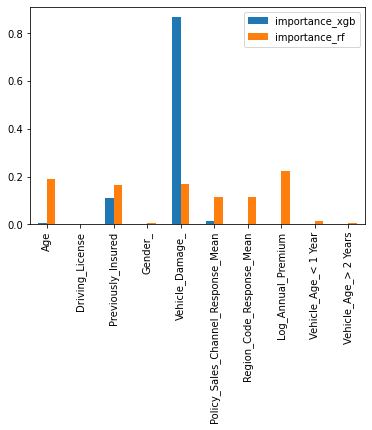

In [11]:
ranking[['importance_xgb', 'importance_rf']].plot.bar()

In [12]:
# pickle this dataframe
pickle.dump(ranking, open('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\projeto\\delivery\\ranking_feature_selection.pkl', 'wb'))

In [13]:
X_smote = np.delete(X_smote, 1, 1)
X_train_smote = np.delete(X_train_smote, 1, 1)
X_valid = np.delete(X_valid, 1, 1)
X_test = np.delete(X_test, 1, 1)

model_columns.pop(1)

'Driving_License'

# 7.0 Exporting data

###### 7.1 Scaler

In [14]:
pickle.dump(X_scaler, open('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\deploy\\transformers\\scaler_standard_scaler.pkl', 'wb'))

###### 7.2 Arrays

In [15]:
data_to_modeling = [X_smote, X_train_smote, X_valid, X_test, y_smote, y_train_smote, y_valid, y_test]
pickle.dump(data_to_modeling, open('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\projeto\\delivery\\data_to_modeling.pkl', 'wb'))

###### 7.4 Columns

In [16]:
pickle.dump(model_columns, open('C:\\Users\\Samoel\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\projeto\\delivery\\model_columns.pkl', 'wb'))

# Time

In [17]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 11 minutos
